In [1]:
import os
os.chdir('..')

In [2]:
import json
from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cross_decomposition import CCA
from modules.constants import FEATURE_LIST

### Read Preprocessed Data

In [3]:
create_data = False
files = list(Path('data/preprocessed/combined').glob('*.csv'))

In [4]:
age_data = pd.read_csv('metadata/combined.csv', dtype={'test_id': str}).set_index('test_id')

### Feature Engineering

In [5]:
def euclidean_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

def safe_arctanh(x):
    if x > -1:
        return np.arctanh(x)
    else:
        return np.nan

def angle_between_vectors(v1, v2):
    v1 = v1.reshape(-1)
    v2 = v2.reshape(-1)
    
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    unit_v1 = v1 / norm_v1
    unit_v2 = v2 / norm_v2

    angle = np.arccos(np.clip(np.dot(unit_v1, unit_v2), -1.0, 1.0))
    return angle

def activity(v):
    return np.var(v)

def mobility(v, epsilon=1e-12):
    a = np.gradient(v)
    a = np.var(a)
    v = np.var(v) + epsilon
    return np.sqrt(a / v)

def complexity(v, epsilon=1e-12):
    num = mobility(np.gradient(v), epsilon=epsilon)
    den = mobility(v, epsilon=epsilon) + epsilon
    num = np.nan_to_num(num, nan=0.0)
    den = np.nan_to_num(den, nan=epsilon)
    return num / den

In [6]:
def calculate_coordination_indices(df):
    # Calculate 3D tangential velocities for hands and feet
    df['left_hand_vel'] = np.gradient(np.linalg.norm(df[['left_wrist_x', 'left_wrist_y', 'left_wrist_z']].values, axis=1))
    df['right_hand_vel'] = np.gradient(np.linalg.norm(df[['right_wrist_x', 'right_wrist_y', 'right_wrist_z']].values, axis=1))
    df['left_foot_vel'] = np.gradient(np.linalg.norm(df[['left_foot_x', 'left_foot_y', 'left_foot_z']].values, axis=1))
    df['right_foot_vel'] = np.gradient(np.linalg.norm(df[['right_foot_x', 'right_foot_y', 'right_foot_z']].values, axis=1))

    # Pearson's correlation coefficients for velocity
    rh = np.corrcoef(df['left_hand_vel'], df['right_hand_vel'])[0, 1]
    rf = np.corrcoef(df['left_foot_vel'], df['right_foot_vel'])[0, 1]

    # Converting velocity correlations to Fisher's Z score
    rh_z = np.arctanh(rh)
    rf_z = np.arctanh(rf)

    # Canonical Correlation Analysis for hands and feet positions
    cca_hands = CCA(n_components=1)
    cca_feet = CCA(n_components=1)
    
    # Run CCA for hands
    cca_hands.fit(df[['left_wrist_x', 'left_wrist_y', 'left_wrist_z']], df[['right_wrist_x', 'right_wrist_y', 'right_wrist_z']])
    ch = cca_hands.score(df[['left_wrist_x', 'left_wrist_y', 'left_wrist_z']], df[['right_wrist_x', 'right_wrist_y', 'right_wrist_z']])

    # Run CCA for feet
    cca_feet.fit(df[['left_foot_x', 'left_foot_y', 'left_foot_z']], df[['right_foot_x', 'right_foot_y', 'right_foot_z']])
    cf = cca_feet.score(df[['left_foot_x', 'left_foot_y', 'left_foot_z']], df[['right_foot_x', 'right_foot_y', 'right_foot_z']])

    # Convert ch and cf to Fisher's Z score
    ch_z = safe_arctanh(ch)
    cf_z = safe_arctanh(cf)
    
    angle_hands = angle_between_vectors(cca_hands.x_rotations_, cca_hands.y_rotations_)
    angle_feet = angle_between_vectors(cca_feet.x_rotations_, cca_feet.y_rotations_)

    return pd.DataFrame([[ch_z, cf_z, angle_hands, angle_feet, rh_z, rf_z]], 
                        columns=['hands_position_cca_z', 'feet_position_cca_z', 'hands_angles_cca_vec', 'feet_angles_cca_vec', 'hands_v_corr_z', 'feet_v_corr_z'])

In [7]:
def calculate_distance_indices(df):
    # Calculate Euclidean distances between right and left limbs
    df['hand_distance'] = euclidean_distance(df['left_wrist_x'], df['left_wrist_y'], df['left_wrist_z'],
                                             df['right_wrist_x'], df['right_wrist_y'], df['right_wrist_z'])
    df['foot_distance'] = euclidean_distance(df['left_foot_x'], df['left_foot_y'], df['left_foot_z'],
                                             df['right_foot_x'], df['right_foot_y'], df['right_foot_z'])

    # Calculate heights of limbs
    df['left_hand_height'] = df['left_wrist_z']
    df['right_hand_height'] = df['right_wrist_z']
    df['left_foot_height'] = df['left_foot_z']
    df['right_foot_height'] = df['right_foot_z']

    # Calculate 5th and 95th percentiles
    hands_distance_5th = np.percentile(df['hand_distance'], 5)
    feet_distance_5th = np.percentile(df['foot_distance'], 5)
    hands_lift_95th = np.percentile(df[['left_hand_height', 'right_hand_height']], 95)
    feet_lift_95th = np.percentile(df[['left_foot_height', 'right_foot_height']], 95)

    # Close-limb and lift-limb probabilities
    L = 0.25  # Threshold for close-limb
    H = 0.10  # Height threshold
    Pch = np.mean(df['hand_distance'] < L)
    Pcf = np.mean(df['foot_distance'] < L)
    Plh = np.mean((df['left_hand_height'] > H) & (df['right_hand_height'] > H))
    Plf = np.mean((df['left_foot_height'] > H) & (df['right_foot_height'] > H))

    df = pd.DataFrame([[hands_distance_5th, feet_distance_5th, hands_lift_95th, feet_lift_95th, Pch, Pcf, Plh, Plf]], 
                        columns=['hands_distance_5th', 'feet_distance_5th', 'hands_lift_95th', 'feet_lift_95th', 'hands_close_prob', 'feet_close_prob', 'hands_lift_prob', 'feet_lift_prob'])
    return df

In [8]:
def calculate_hjorth_indices(df):
    fps = 30 # fps
    window_len = fps * 1 # 1 second windows
    overlap = 0.5 # 50% overlap
    num_windows = (df.shape[0]*2) // window_len
    final_feats = ['left_wrist', 'right_wrist', 'left_foot', 'right_foot']
    
    act = np.zeros((num_windows, len(final_feats)//2))
    mob = np.zeros((num_windows, len(final_feats)//2))
    com = np.zeros((num_windows, len(final_feats)//2))

    for i, f in enumerate(final_feats):
        velocity_vectors = np.subtract(df[[f'{f}_x', f'{f}_y', f'{f}_z']].values, df[[f'{f}_x', f'{f}_y', f'{f}_z']].iloc[0].values)
        norm_velocity = np.linalg.norm(velocity_vectors, axis=1)

        for w in range(1, num_windows-1): # Skipping first and last windows
            v_w = norm_velocity[int((w*window_len)*overlap):int(((w*window_len)*overlap)+window_len)]
            
            # Hjorth activity, mobility, and complexity averaged across body sides
            act[w, i//2] += activity(v_w) / 2
            mob[w, i//2] += mobility(v_w) / 2
            com[w, i//2] += complexity(v_w) / 2

    # Averaging across windows
    row_act = np.nanmean(act[1:-1, :], axis=0)
    row_mob = np.nanmean(mob[1:-1, :], axis=0)
    row_com = np.nanmean(com[1:-1, :], axis=0)

    body_parts = ['hands', 'feet']
    columns = [f'{body_parts[i//2]}_{param}' for i in range(0, len(final_feats), 2) for param in ['activity', 'mobility', 'complexity']]

    hj_all = pd.DataFrame([np.hstack((row_act, row_mob, row_com))], columns=columns)
    return hj_all

In [9]:
if create_data:
    ages = []
    test_ids = []
    segments = []
    segment_lengths = []
    outcomes = []
    coordination_indices_data = []
    distance_indices_data = []
    hjorth_indices_data = []

    for idx in tqdm(range(len(files))):
        df = pd.read_csv(files[idx])
        
        # Flip infant to irl pose
        for col in df.columns:
            if col.endswith('_x') or col.endswith('_z'):
                df[col] = -df[col]

        infant_id = files[idx].name.split('_')[0]
        
        test_ids.append(infant_id)
        segments.append(files[idx].stem)
        segment_lengths.append(df.shape[0])
        ages.append(age_data.loc[infant_id].corrected_age)
        outcomes.append(age_data.loc[infant_id].outcome)

        coordination_indices_infant = calculate_coordination_indices(df)
        coordination_indices_data.append(coordination_indices_infant)

        distance_indices_infant = calculate_distance_indices(df)
        distance_indices_data.append(distance_indices_infant)

        hjorth_indices_infant = calculate_hjorth_indices(df)
        hjorth_indices_data.append(hjorth_indices_infant)

    coordination_indices_df = pd.concat(coordination_indices_data)
    distance_indices_df = pd.concat(distance_indices_data)
    hjorth_indices_df = pd.concat(hjorth_indices_data)

    y = pd.DataFrame({'segment': segments, 'segment_length': segment_lengths, 
                      'test_id': test_ids, 'outcome': outcomes, 'corrected_age': ages})

    coordination_indices_df.index = y.index
    distance_indices_df.index = y.index
    hjorth_indices_df.index = y.index

    df = pd.concat([y, coordination_indices_df, distance_indices_df, hjorth_indices_df], axis=1)
    
    # Some CCA R2 values are below Z-score threshold -1 and transformed to NaN, replace with min value
    df['hands_position_cca_z'] = df['hands_position_cca_z'].fillna(df.hands_position_cca_z.min())
    df['feet_position_cca_z'] = df['feet_position_cca_z'].fillna(df.feet_position_cca_z.min())
    
    df.to_csv('data/all_features.csv', index=False)

In [10]:
df = pd.read_csv('data/all_features.csv')
df.head()

,segment,segment_length,test_id,outcome,corrected_age,hands_position_cca_z,feet_position_cca_z,hands_angles_cca_vec,feet_angles_cca_vec,hands_v_corr_z,...,hands_close_prob,feet_close_prob,hands_lift_prob,feet_lift_prob,hands_activity,hands_mobility,hands_complexity,feet_activity,feet_mobility,feet_complexity
0,v57_1,6601,v57,0,105,0.608073,1.036887,0.332822,0.046752,0.996067,...,0.998031,0.753674,0.986669,0.413422,0.003383,0.035758,0.451173,0.417625,1.792053,1.909829
1,0011_1,8279,0011,0,103,-0.108152,0.157440,1.219561,0.516766,0.036060,...,0.436647,0.899263,0.428796,0.480734,0.005121,0.004228,0.446643,0.426423,1.802441,1.886827
2,0093_1,3091,0093,2,61,-3.018320,0.233271,0.989983,0.360775,0.117989,...,0.628276,0.970560,0.867357,0.745066,0.002897,0.000966,0.436136,0.406690,1.828193,1.989065
3,v42_2,3915,v42,0,121,-0.089294,1.281309,0.324008,0.259617,0.076882,...,0.000255,0.665134,0.410473,0.507280,0.023735,0.029814,0.466184,0.383112,1.701167,2.009668
4,0046_2,524,0046,2,43,-1.477051,0.177046,2.268219,0.905617,0.021706,...,0.120229,0.719466,0.715649,0.137405,0.006631,0.005301,0.433700,0.435104,1.826915,1.946131


### Weighted average

In [11]:
# Group by test_id and calculate the total length for each test_id
total_length_per_test_id = df.groupby('test_id')['segment_length'].sum()

# Merge the total lengths back into the main dataframe
df = df.merge(total_length_per_test_id, on='test_id', suffixes=('', '_total'))

# Calculate the weight for each segment as its length divided by the total length for its test_id
df['weight'] = df['segment_length'] / df['segment_length_total']

# For each test_id, calculate the weighted average of all features
weighted_df = df.groupby('test_id').apply(
    lambda x: pd.Series({
        col: (x[col] * x['weight']).sum() for col in FEATURE_LIST
    })
)
weighted_df.reset_index(inplace=True)

static_features = df[['test_id', 'outcome', 'corrected_age']].drop_duplicates()
df = pd.merge(static_features, weighted_df, on='test_id')
df.to_csv('data/grouped_features.csv', index=False)
df.head()

,test_id,outcome,corrected_age,hands_position_cca_z,feet_position_cca_z,hands_angles_cca_vec,feet_angles_cca_vec,hands_v_corr_z,feet_v_corr_z,hands_distance_5th,...,hands_close_prob,feet_close_prob,hands_lift_prob,feet_lift_prob,hands_activity,hands_mobility,hands_complexity,feet_activity,feet_mobility,feet_complexity
0,v57,0,105,0.608073,1.036887,0.332822,0.046752,0.996067,1.147362,0.029972,...,0.998031,0.753674,0.986669,0.413422,0.003383,0.035758,0.451173,0.417625,1.792053,1.909829
1,0011,0,103,-0.108152,0.157440,1.219561,0.516766,0.036060,0.730028,0.128513,...,0.436647,0.899263,0.428796,0.480734,0.005121,0.004228,0.446643,0.426423,1.802441,1.886827
2,0093,2,61,-2.552931,0.258891,1.119357,0.407773,0.134452,0.482790,0.105634,...,0.565172,0.959768,0.792013,0.607482,0.004203,0.001366,0.418965,0.397251,1.912734,1.999128
3,v42,0,121,-0.086533,0.845392,0.586824,0.723713,0.087897,0.822441,0.328731,...,0.019012,0.594870,0.365574,0.491387,0.026759,0.037042,0.478110,0.403028,1.678625,1.912436
4,0046,2,43,-2.021250,0.046318,2.177452,0.600547,0.360542,0.378487,0.136565,...,0.423777,0.804278,0.557536,0.215515,0.006550,0.002721,0.422834,0.437086,1.909490,1.795475


### Create df for feature retrieval by segment

In [12]:
files = list(Path('data/rotated/combined').glob('*.csv'))
ages = []
test_ids = []
segments = []
segment_lengths = []
outcomes = []

for idx in tqdm(range(len(files))):
    infant_id = files[idx].name.split('_')[0]
    test_ids.append(infant_id)
    segments.append(files[idx].stem)
    ages.append(age_data.loc[infant_id].corrected_age)
    outcomes.append(age_data.loc[infant_id].outcome)

df_info = pd.DataFrame({'segment': segments, 'test_id': test_ids, 'outcome': outcomes, 'corrected_age': ages})
df_grouped = pd.read_csv('data/grouped_features.csv')

for feature in FEATURE_LIST:
    df_info[feature] = df_info['test_id'].map(df_grouped.set_index('test_id')[feature])

df_info.to_csv('data/features.csv', index=False)
df_info.head()

  0%|          | 0/1890 [00:00<?, ?it/s]

,segment,test_id,outcome,corrected_age,hands_position_cca_z,feet_position_cca_z,hands_angles_cca_vec,feet_angles_cca_vec,hands_v_corr_z,feet_v_corr_z,...,hands_close_prob,feet_close_prob,hands_lift_prob,feet_lift_prob,hands_activity,hands_mobility,hands_complexity,feet_activity,feet_mobility,feet_complexity
0,v63_1_9,v63,0,135,0.298131,0.864937,1.073053,0.212958,0.144398,0.827106,...,0.319601,0.552629,0.879889,0.044911,0.002688,0.006520,0.384195,0.331816,2.034340,2.210027
1,0078_2_7,0078,0,117,0.121431,0.540297,2.039207,0.184360,0.523759,0.723712,...,0.908468,0.934996,0.972944,0.476283,0.001852,0.003995,0.443954,0.399443,1.846396,2.001339
2,0028_1_9,0028,1,91,-0.136205,0.222133,2.484061,0.127616,0.184767,0.512884,...,0.701367,0.898431,0.923739,0.242619,0.004314,0.003018,0.381250,0.382515,2.016825,1.939391
3,v30_5_5,v30,0,104,0.199978,0.387210,0.684571,0.095049,0.389825,0.820785,...,0.396880,0.859422,0.505625,0.356550,0.011028,0.006796,0.446642,0.387933,1.807391,1.933277
4,0089_2_7,0089,0,95,0.020637,0.665044,0.128481,0.567511,0.274843,0.316880,...,0.573312,0.801540,0.793543,0.584123,0.001450,0.003496,0.413658,0.383355,1.906969,2.019783


In [13]:
def show_correlation(df, method):
    corr = df.corr(method=method)
    score = corr.loc['corrected_age'].drop(['corrected_age']).round(2)
    display(score.to_frame(name='Correlation with Corrected Age'))
    return score

In [14]:
scores = show_correlation(df, 'pearson')

,Correlation with Corrected Age
outcome,-0.19
hands_position_cca_z,0.28
feet_position_cca_z,0.20
hands_angles_cca_vec,-0.25
feet_angles_cca_vec,-0.26
hands_v_corr_z,0.17
feet_v_corr_z,0.07
hands_distance_5th,0.13
feet_distance_5th,-0.12
hands_lift_95th,0.19


In [15]:
scores = show_correlation(df, 'spearman')

,Correlation with Corrected Age
outcome,-0.14
hands_position_cca_z,0.18
feet_position_cca_z,0.16
hands_angles_cca_vec,-0.29
feet_angles_cca_vec,-0.23
hands_v_corr_z,0.13
feet_v_corr_z,0.12
hands_distance_5th,0.01
feet_distance_5th,-0.19
hands_lift_95th,0.17


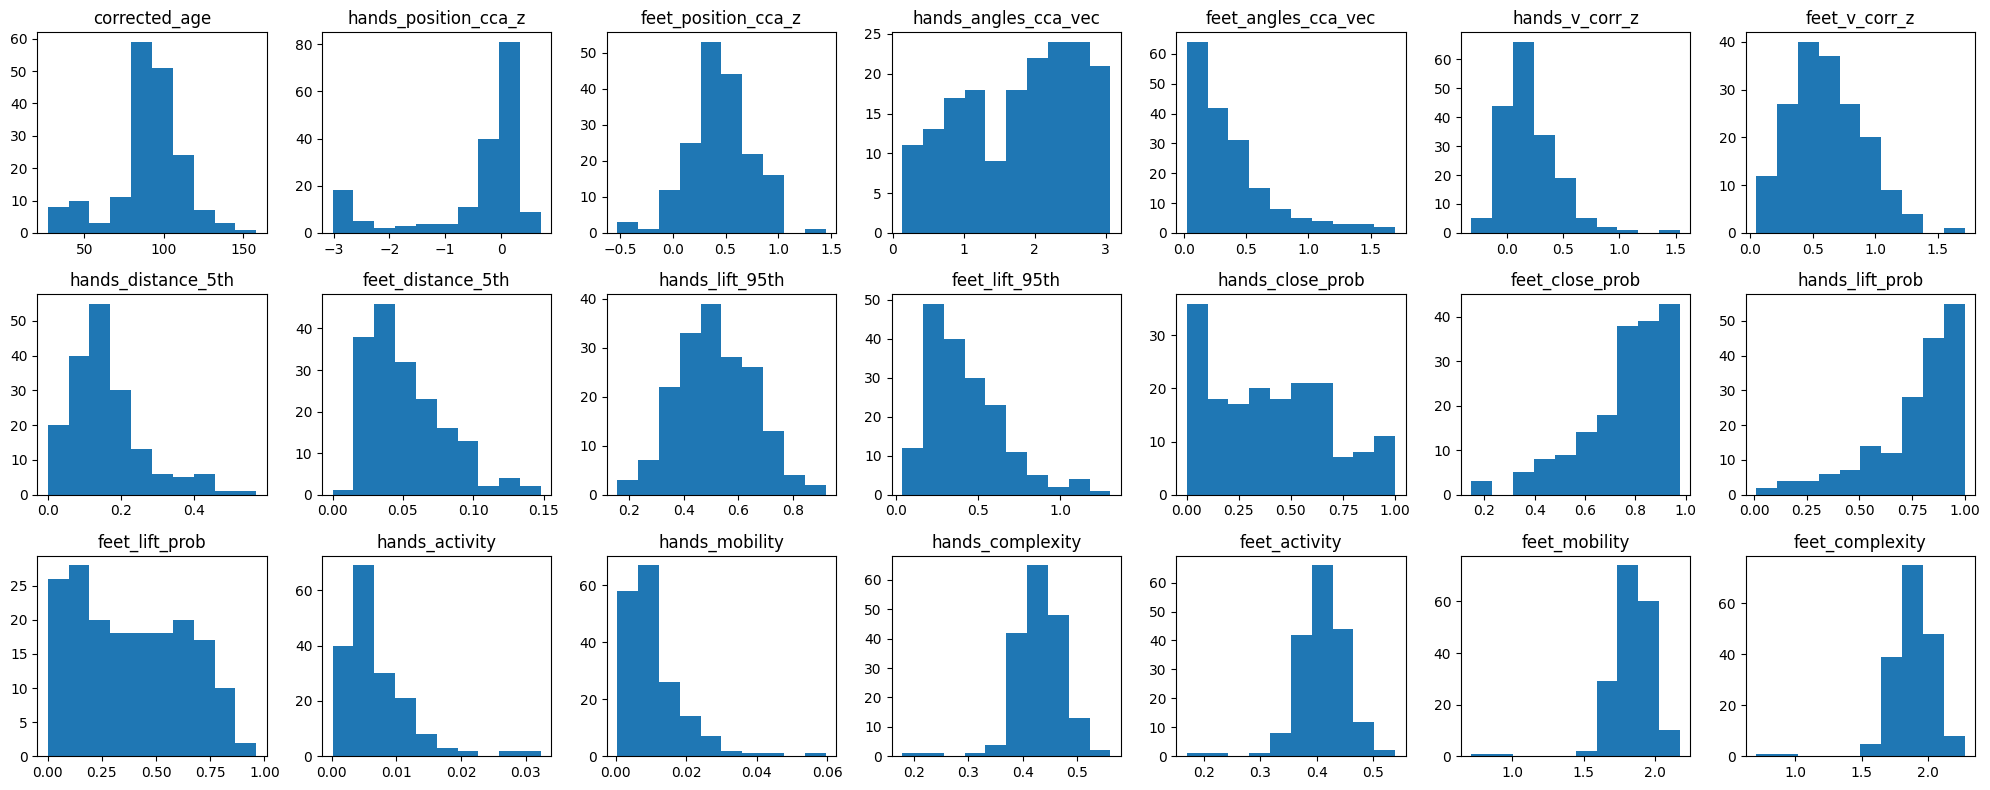

In [16]:
plt.figure(figsize=(20, 8))

n_rows = 3
n_cols = 7

for i, column in enumerate(df.columns[2:]):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df[column])
    plt.title(column)
    plt.tight_layout()

plt.show()

### Machine Learning

In [17]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from modules.constants import FEATURE_LIST
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from collections import defaultdict
from joblib import dump

In [18]:
features = FEATURE_LIST
target = 'corrected_age'

In [19]:
outcome_2_subset = age_data[age_data['outcome'] == 2]
remaining_data = age_data[age_data['outcome'] != 2]

age_train, age_val = train_test_split(remaining_data, test_size=0.1, random_state=42)
age_val = pd.concat([age_val, outcome_2_subset])

train_ids = age_train.index.values
val_ids = age_val.index.values

X_train, y_train = df[df['test_id'].isin(train_ids)][features], df[df['test_id'].isin(train_ids)][target]
X_val, y_val = df[df['test_id'].isin(val_ids)][features], df[df['test_id'].isin(val_ids)][target]

In [20]:
# LR on selected fts
fts = ['hands_complexity', 'hands_lift_prob']

model = LinearRegression()
model.fit(X_train[fts], y_train)

y_pred_lr = model.predict(X_val[fts])
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)
print(f'LR: RMSE {rmse_lr:.2f}, R2 {r2_lr:.2f}')

LR: RMSE 28.06, R2 -0.04


In [21]:
# Linear Regression with all features
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr))
r2_lr = r2_score(y_val, y_pred_lr)

# Random Forest
rf = RandomForestRegressor(random_state=1, n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
r2_rf = r2_score(y_val, y_pred_rf)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=1, n_estimators=100, max_depth=3, learning_rate=0.05)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_val)
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb))
r2_gb = r2_score(y_val, y_pred_gb)

# eXtreme Gradient Boosting
xgb = XGBRegressor(random_state=1, n_estimators=100, max_depth=3, learning_rate=0.05)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f'LR: RMSE {rmse_lr:.2f}, R2 {r2_lr:.2f}')
print(f'RF: RMSE {rmse_rf:.2f}, R2 {r2_rf:.2f}')
print(f'GB: RMSE {rmse_gb:.2f}, R2 {r2_gb:.2f}')
print(f'XGB: RMSE {rmse_xgb:.2f}, R2 {r2_xgb:.2f}')

LR: RMSE 25.08, R2 0.17
RF: RMSE 27.63, R2 -0.00
GB: RMSE 26.01, R2 0.11
XGB: RMSE 27.15, R2 0.03


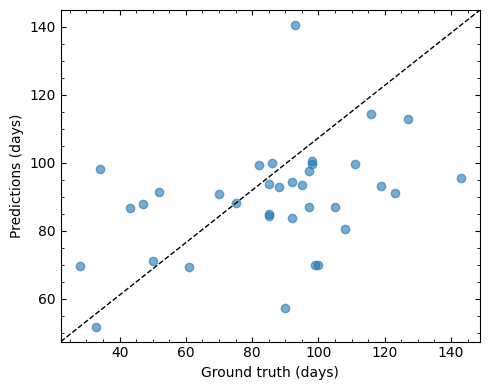

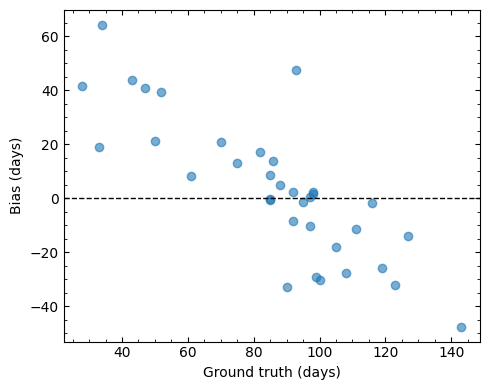

In [22]:
plt.figure(figsize=(5, 4))
plt.axline((y_val.min(), y_pred_gb.min()), (y_val.max(), y_pred_gb.max()), color='k', lw=1, ls='--')
plt.scatter(y_val, y_pred_gb, alpha=0.6)
plt.xlabel('Ground truth (days)')
plt.ylabel('Predictions (days)')
plt.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
plt.minorticks_on()
plt.tight_layout()
plt.show()

residuals = y_pred_gb - y_val
plt.figure(figsize=(5, 4))
plt.axhline(0, color='k', ls='--', lw=1)
plt.scatter(y_val, residuals, alpha=0.6)
plt.xlabel('Ground truth (days)')
plt.ylabel('Bias (days)')
plt.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
plt.minorticks_on()
plt.tight_layout()
plt.show()

In [23]:
df['outcome_label'] = df['outcome'].map({0: 'Normal', 1: 'Mild', 2: 'Severe'})
val_with_labels = df[df['test_id'].isin(val_ids)]

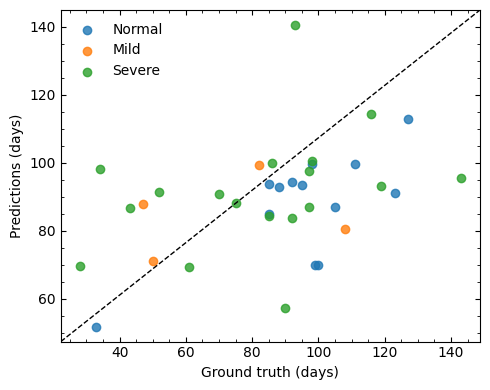

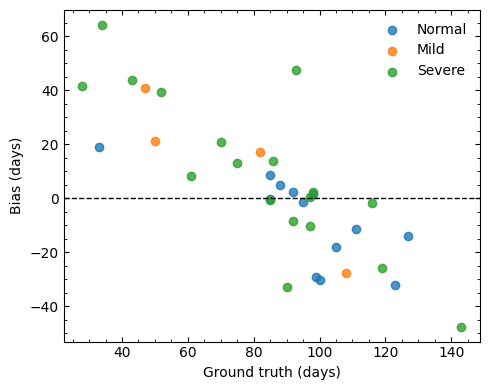

In [24]:
pred_df = val_with_labels.copy()
pred_df['predictions_gb'] = y_pred_gb

grouped = pred_df.groupby('test_id').mean()

outcome_labels = pred_df[['test_id', 'outcome_label']].drop_duplicates().set_index('test_id')

plt.figure(figsize=(5, 4))
for label in ['Normal', 'Mild', 'Severe']:
    label_ids = outcome_labels[outcome_labels['outcome_label'] == label].index
    subset = grouped.loc[label_ids]

    plt.scatter(subset[target], subset['predictions_gb'], label=label, alpha=0.8)

plt.axline((grouped[target].min(), grouped['predictions_gb'].min()), (grouped[target].max(), grouped['predictions_gb'].max()), color='k', lw=1, ls='--')
plt.xlabel('Ground truth (days)')
plt.ylabel('Predictions (days)')
plt.legend(frameon=False)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
plt.minorticks_on()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
for label in ['Normal', 'Mild', 'Severe']:
    label_ids = outcome_labels[outcome_labels['outcome_label'] == label].index
    subset = grouped.loc[label_ids]
    
    residuals = subset['predictions_gb'] - subset[target]
    plt.scatter(subset[target], residuals, label=label, alpha=0.8)

plt.axhline(0, color='k', ls='--', lw=1)
plt.xlabel('Ground truth (days)')
plt.ylabel('Bias (days)')
plt.legend(frameon=False)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, top=True, left=True, right=True)
plt.minorticks_on()
plt.tight_layout()
plt.show()

### Grid Search over _k_-Folds

In [25]:
num_folds = 10
root_dir = 'results'

param_grid = {
    'lr': {},
    'rf': {'n_estimators': [100, 300, 500, 700, 900], 'max_depth': [1, 3, 5, 7, 9], 'learning_rate': [None]},
    'gb': {'n_estimators': [100, 300, 500, 700, 900], 'max_depth': [1, 3, 5, 7, 9], 'learning_rate': [0.1, 0.15, 0.2, 0.25]},
    'xgb': {'n_estimators': [100, 300, 500, 700, 900], 'max_depth': [1, 3, 5, 7, 9], 'learning_rate': [0.1, 0.15, 0.2, 0.25]},
}

In [26]:
# Initialize variables to store the best results
best_params = {name: None for name in param_grid}
best_rmse = {name: float('inf') for name in param_grid}
total_rmse = {name: [] for name in param_grid}

kf = KFold(n_splits=num_folds, shuffle=False)

age_data = age_data[age_data.outcome != 2]

for fold_n, (train_index, val_index) in enumerate(kf.split(age_data), start=1):
    train_ids = age_data.iloc[train_index].index.values
    val_ids = age_data.iloc[val_index].index.values
    
    df_train = df[df['test_id'].isin(train_ids)]
    df_val = df[df['test_id'].isin(val_ids)]

    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]

    # Linear Regression (no grid search needed)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_val_lr = lr.predict(X_val)
    rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_val_lr))
    total_rmse['lr'].append(rmse_lr)

    # Grid Search for RF, GB, XGB
    for model_name in tqdm(['rf', 'gb', 'xgb'], desc=f'Running grid search for fold {fold_n}'):
        for n_estimators in param_grid[model_name]['n_estimators']:
            for max_depth in param_grid[model_name]['max_depth']:
                for learning_rate in param_grid[model_name]['learning_rate']:
                    model = None
                    if model_name == 'rf':
                        model = RandomForestRegressor(
                            random_state=1,
                            n_estimators=n_estimators,
                            max_depth=max_depth)
                    elif model_name == 'gb':
                        model = GradientBoostingRegressor(
                            random_state=1,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate)
                    elif model_name == 'xgb':
                        model = XGBRegressor(
                            random_state=1,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate)

                    model.fit(X_train, y_train)
                    y_pred_val = model.predict(X_val)
                    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

                    # Update total RMSE
                    total_rmse[model_name].append((rmse, n_estimators, max_depth, learning_rate))

Running grid search for fold 1:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 2:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 3:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 5:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 7:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 9:   0%|          | 0/3 [00:00<?, ?it/s]

Running grid search for fold 10:   0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
# Calculate average RMSE and determine best parameters
for model_name in ['rf', 'gb', 'xgb']:
    grouped_rmse = defaultdict(list)
    for rmse, n_estimators, max_depth, learning_rate in total_rmse[model_name]:
        grouped_rmse[(n_estimators, max_depth, learning_rate)].append(rmse)
        
    # Calculate average RMSE for each parameter combination
    avg_rmses = {params: np.mean(rmses) for params, rmses in grouped_rmse.items()}

    # Determine best parameters
    best_params[model_name], best_rmse[model_name] = min(avg_rmses.items(), key=lambda x: x[1])    

best_rmse['lr'] = np.mean(total_rmse['lr'])

for model_name in ['lr', 'rf', 'gb', 'xgb']:
    print(f"{model_name.upper()}: Best RMSE = {best_rmse[model_name]:.2f}, Best Params = {best_params.get(model_name, 'N/A')}")

LR: Best RMSE = 19.50, Best Params = None
RF: Best RMSE = 18.86, Best Params = (300, 7, None)
GB: Best RMSE = 18.12, Best Params = (300, 1, 0.2)
XGB: Best RMSE = 18.02, Best Params = (700, 1, 0.15)


In [28]:
# Train and save the best models for each fold
for fold_n, (train_index, val_index) in enumerate(kf.split(age_data), start=1):
    train_ids = age_data.iloc[train_index].index.values
    val_ids = age_data.iloc[val_index].index.values

    df_train = df[df['test_id'].isin(train_ids)]
    df_val = df[df['test_id'].isin(val_ids)]

    X_train, y_train = df_train[features], df_train[target]
    X_val, y_val = df_val[features], df_val[target]

    for model_name in tqdm(['lr', 'rf', 'gb', 'xgb'], desc=f'Predicting for fold {fold_n}'):
        output_dir = os.path.join(root_dir, model_name, f'fold_{fold_n}')
        os.makedirs(output_dir, exist_ok=True)

        model = None
        if model_name == 'lr':
            model = LinearRegression()
        elif model_name == 'rf':
            model = RandomForestRegressor(
                random_state=1, 
                n_estimators=best_params[model_name][0], 
                max_depth=best_params[model_name][1])
        elif model_name == 'gb':
            model = GradientBoostingRegressor(
                random_state=1,
                n_estimators=best_params[model_name][0],
                max_depth=best_params[model_name][1],
                learning_rate=best_params[model_name][2])
        elif model_name == 'xgb':
            model = XGBRegressor(
                random_state=1,
                n_estimators=best_params[model_name][0],
                max_depth=best_params[model_name][1],
                learning_rate=best_params[model_name][2])

        model.fit(X_train, y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        # Save the model
        dump(model, Path(output_dir, 'model.joblib'))

        # Save predictions
        np.save(Path(output_dir, 'train_predictions.npy'), y_pred_train)
        np.save(Path(output_dir, 'val_predictions.npy'), y_pred_val)

        # Save metadata
        metadata = {
            'best_params': best_params.get(model_name, {}),
            'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val)),
            'train_segments': df_train.test_id.tolist(),
            'val_segments': df_val.test_id.tolist(),
            'model_name': model_name,
            'fold': fold_n
        }

        with open(Path(output_dir, 'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)

Predicting for fold 1:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 2:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 3:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 4:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 5:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 6:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 7:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 8:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 9:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting for fold 10:   0%|          | 0/4 [00:00<?, ?it/s]

### Predictions

In [29]:
import pandas as pd
import numpy as np
import json
from joblib import load

model_dirs = ['results/lr', 'results/rf', 'results/gb', 'results/xgb']
age_data_file = 'metadata/combined.csv'
feature_data_file = 'data/grouped_features.csv'
output_dir = 'results'

# Load age and feature data
age_data = pd.read_csv(age_data_file, dtype={'test_id': str})
age_data_pred = age_data[age_data.outcome == 2]
fts_data = pd.read_csv(feature_data_file)

# Iterate over each model and its folds
for model_dir in model_dirs:
    model_name = model_dir.split('/')[-1]

    # Prepare the DataFrame for storing predictions for the current model
    model_predictions = pd.DataFrame(columns=['fold', 'segment', 'test_id', 'outcome', 'y_true', 'y_pred'])

    for fold_n in range(1, 6):
        fold_dir = f'{model_dir}/fold_{fold_n}'
        
        # Load the model
        model = load(f'{fold_dir}/model.joblib')

        # Load metadata for the fold
        with open(f'{fold_dir}/metadata.json', 'r') as f:
            metadata = json.load(f)

        # Filter features data for prediction
        predict_fts = fts_data[fts_data['test_id'].isin(age_data_pred['test_id'])]
        X_predict = predict_fts[FEATURE_LIST]
        y_true = predict_fts['corrected_age'].values

        # Predict
        y_pred = model.predict(X_predict)

        # Append predictions to the DataFrame
        fold_predictions = pd.DataFrame({
            'fold': fold_n,
            'segment': predict_fts['test_id'],
            'test_id': predict_fts['test_id'],
            'outcome': predict_fts['outcome'],
            'y_true': y_true,
            'y_pred': y_pred
        })
        model_predictions = pd.concat([model_predictions, fold_predictions], ignore_index=True)

    # Save the predictions for the current model
    model_predictions.to_csv(f'predictions/{model_name}_predictions.csv', index=False)

model_predictions.head()

,fold,segment,test_id,outcome,y_true,y_pred
0,1,0093,0093,2,61,67.164169
1,1,0046,0046,2,43,78.690498
2,1,0091,0091,2,52,79.775803
3,1,0061,0061,2,97,68.406578
4,1,0082,0082,2,86,80.726105
